In [19]:
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Lazy imports so pylint compains, therefore we disable it
from tensorflow.keras.utils import to_categorical  # type: ignore
from tensorflow.keras import models, layers, optimizers  # type: ignore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import re
import os

In [20]:
# If Google Colab
is_colab_used = False
folder_path = "./data/full-dataset/train/clean"
if is_colab_used:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    folder_path = "/content/drive/My Drive/CS4243/"

# 1. Collect All Raw Data

In [21]:
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df["label"] = df["file_name"].str.split("-0").str[0]

print(f"Number of unique images: {len(df['label'].unique())}")

# # Debug - Get subset of dataframe
# df = df[0:100]

Number of unique images: 7744


# 2. Pre-process Data for Training the Model

In [22]:
def replace_black_with_surrounding_color_optimized(img):
    result = img.copy()

    height, width, _ = img.shape

    # Create a mask where black pixels are True (shape: (height, width))
    black_mask = np.all(img == [0, 0, 0], axis=-1)

    # Initialize an array to accumulate the surrounding pixel values
    accumulator = np.zeros_like(img, dtype=np.float32)

    # Initialize a count of surrounding non-black pixels for each black pixel
    surrounding_count = np.zeros((height, width), dtype=np.float32)

    # Loop through the 8 surrounding pixels (dy, dx in {-1, 0, 1}, skipping (0, 0))
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue  # Skip the black pixel itself

            # Roll the image to get the surrounding pixels
            rolled_img = np.roll(np.roll(img, shift=dy, axis=0), shift=dx, axis=1)

            # Create a mask of the surrounding non-black pixels
            non_black_mask = np.all(rolled_img != [0, 0, 0], axis=-1)

            # Only accumulate colors from non-black pixels
            accumulator += rolled_img * non_black_mask[..., np.newaxis]

            # Update the surrounding count for non-black pixels
            surrounding_count += non_black_mask

    # Avoid division by zero: replace zeros in surrounding_count with 1 to prevent errors
    surrounding_count[surrounding_count == 0] = 1

    # For black pixels, replace them with the average color of surrounding pixels
    result[black_mask] = (
        accumulator[black_mask] / surrounding_count[black_mask, np.newaxis]
    ).astype(np.uint8)

    return result


def process_image(image_path, output_folder):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    if img is not None:
        # Apply the optimized function to clean the image
        cleaned_image = replace_black_with_surrounding_color_optimized(img)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Construct the new file path (same filename, different folder)
        output_path = os.path.join(output_folder, os.path.basename(image_path))

        # Save the cleaned image to the new folder
        cv2.imwrite(output_path, cleaned_image)

        return output_path
    else:
        print(f"Error: Could not load image at {image_path}")
        return None


def process_images(image_paths, output_folder):
    results = []
    for path in tqdm(image_paths):
        results.append(process_image(path, output_folder))
    return results


output_folder = os.path.join("./data", "cleaned_images")
df["processed_images"] = process_images(
    df["original_file_path"].tolist(), output_folder
)

100%|██████████| 7744/7744 [00:46<00:00, 164.89it/s]


# 3. Format Data for Training the Model

In [23]:
# Function to process images and extract ROIs
output_char_folder = os.path.join("./data", "extracted_chars")
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)
contour_too_small_threshold = 8


def extract_rois(image_path):
    # Load the processed image
    img = cv2.imread(image_path)

    if img is not None:
        # Convert to grayscale and threshold
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 75), 2)

        # Sort contours from left to right
        sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        rois = []  # List to store ROIs for display later
        for contour in sorted_contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w <= contour_too_small_threshold and h <= contour_too_small_threshold:
                continue

            # Draw bounding box on the image (optional)
            cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (36, 255, 12), 2)

            # Extract ROI and store it TESTINGGGGGG
            ROI = img[y : y + h, x : x + w]

            # Padding and resizing
            if w > h:
                # Add padding to the top and bottom
                pad_top = (w - h) // 2
                pad_bottom = w - h - pad_top
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    pad_top,
                    pad_bottom,
                    0,
                    0,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )
            else:
                # Add padding to the left and right
                pad_left = (h - w) // 2
                pad_right = h - w - pad_left
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    0,
                    0,
                    pad_left,
                    pad_right,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )

            resized_ROI = cv2.resize(ROI_padded, (32, 32))
            rois.append(resized_ROI)

        return img_with_contours, rois  # Return both the image with contours and ROIs
    else:
        print(f"Error: Could not load image at {image_path}")
        return None, []


# Apply the ROI extraction to processed images in the DataFrame
df["rois"] = df["processed_images"].progress_apply(lambda path: extract_rois(path))

# # Debug - Display results
# for index, (contours_image, rois) in enumerate(zip(df['rois'].apply(lambda x: x[0]), df['rois'].apply(lambda x: x[1]))):
#     plt.figure(figsize=(10, 5))

#     # Display image with bounding boxes
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
#     plt.title("Image with Contours")
#     plt.axis('off')

#     # Display ROIs
#     plt.subplot(1, 2, 2)
#     for i, roi in enumerate(rois):
#         plt.subplot(1, len(rois), i + 1)
#         plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
#         plt.title(f"CHAR {i + 1}")
#         plt.axis('off')
#     plt.show()

100%|██████████| 7744/7744 [00:02<00:00, 2838.53it/s]


# 4. Cleaned Data Collection For Training


len(X):  7744
len(y):  7744
Sample image:


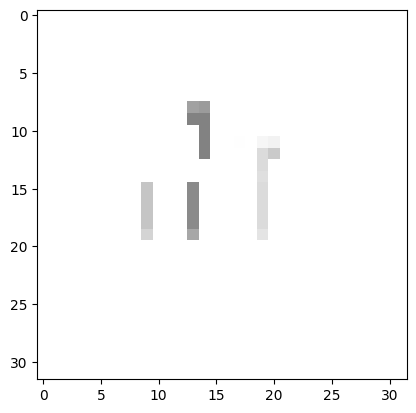

In [24]:
X = []
Y = []

folder_path = "./data/cleaned_images"
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df["label"] = df["file_name"].str.split("-0").str[0]

for filename in os.listdir(folder_path):
    re_match = re.search(r"(\d+)(?=\.png)", filename)
    if not re_match:
        print(f"Could not read {filename}, skipping")
        continue

    digit = int(re_match.group(1))
    if digit != 0 or not is_colab_used:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize the image to 32x32 pixels
            resized_image = cv2.resize(image, (32, 32))
            X.append(resized_image)
            Y.append(filename[digit - 1])
        else:
            print(f"Could not read {filename} from {file_path}, skipping")

print("len(X): ", len(X))
print("len(y): ", len(Y))
print("Sample image:")
rand_idx = np.random.randint(0, len(X))
plt.imshow(cv2.cvtColor(X[rand_idx], cv2.COLOR_BGR2RGB))

X = np.array(X)
Y = np.array(Y)

# 5. Preparing Processed Data for Training


In [25]:
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters


# Normalize
def normalize_data(data):
    return data / 255.0


# One hot encoding
def one_hot_encode_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    encoded = label_encoder.transform(labels)
    categorical = to_categorical(encoded, num_classes=len(char_list))

    return categorical


X = normalize_data(X)
Y = one_hot_encode_labels(Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# 6. Building Model


In [26]:
# Build Model Function
def build_model(learning_rate=0.01, dropout_rate=0.5):
    model = models.Sequential()
    model.add(
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 1)
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(36, activation="softmax"))  # 0-9, a-z

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Train Model Function
def train_model(X, y):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=36)

    model = build_model(input_shape=X.shape[1:])  # Using input shape from X
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(X, y_categorical, epochs=10, batch_size=32)

    return model, label_encoder


# Predict Function
def predict_model(model, label_encoder, X):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    return predicted_labels

# 7. Cross Validation


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model()

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10


/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9357 - loss: 0.3134 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9991 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0502 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9990 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 1

# 8. Hyperparameter Tuning


In [28]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the grid of hyperparameters
param_grid = {
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__dropout_rate": [0.0, 0.2, 0.5],
}

# Conduct the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")

/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vishnusundaresan/Documents/School/CS4243/.v

Best Hyperparameters: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.01}


# 9. Build and Save the Model

In [29]:
model = build_model(learning_rate=0.001, dropout_rate=0.5)

# Save the model
from datetime import datetime
from zoneinfo import ZoneInfo

model.save(f"model-{datetime.now(tz=ZoneInfo('UTC'))}.keras")